In [1]:
from datetime import datetime, timedelta
import datetime
import pandas as pd
import requests
import pytz
from timezonefinder import TimezoneFinder
from io import StringIO
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astral import LocationInfo
from astral.sun import sun
from astral.sun import elevation
from matplotlib import rcParams
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator

In [2]:
# Load credentials; input the correct address
with open('') as f:
    creds = json.load(f)

token = creds["token"]
org = creds["orgname"]
bucket = creds["bucket"]
url = f"http://mdash.circ.utdallas.edu:8086/api/v2/query?org={org}"

headers = {
    "Authorization": f"Token {token}",
    "Accept": "application/csv",
    "Content-type": "application/vnd.flux"
}


In [3]:
# Set the initial datetime and node
d = datetime.datetime(2024, 7, 1, 0, 0, 0)
node = "vaLo Node 01"

dstart = d - datetime.timedelta(minutes=120)
dend = d + datetime.timedelta(days=1, minutes=25)


In [4]:
# GPS query from InfluxDB
query_gps = f"""
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{d.isoformat()}Z"), stop: time(v: "{(d + datetime.timedelta(days=1)).isoformat()}Z"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "GPSGPGGA2")
  |> filter(fn: (r) => r["_field"] == "latitudeCoordinate" or r["_field"] == "longitudeCoordinate" or r["_field"] == "altitude")
  |> aggregateWindow(every: 1m, fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "latitudeCoordinate", "longitudeCoordinate", "altitude"])
"""
resp = requests.post(url, headers=headers, data=query_gps)
df = pd.read_csv(StringIO(resp.text))
df.drop(columns=['result', 'table', '_time','Unnamed: 0'], inplace=True)
df.dropna(inplace=True)

In [5]:
pos = {
    'lat': df['latitudeCoordinate'].mean(),
    'lon': df['longitudeCoordinate'].mean(),
    'alt': df['altitude'].mean()
}

# Get the timezone at the given latitude and longitude
tf = TimezoneFinder()
tzone = tf.timezone_at(lat=pos['lat'], lng=pos['lon'])

# Set the timezone for the datetime
d = pytz.timezone(tzone).localize(d)
dstart = d - datetime.timedelta(minutes=120)
dend = d + datetime.timedelta(days=1, minutes=25)


In [6]:
def process_df(response, tzone, d):
    df = pd.read_csv(StringIO(response.text))
    df = df.drop(columns=['Unnamed: 0', 'result', 'table'])
    df = df.rename(columns={'_time': 'datetime'})
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['datetime'] = df['datetime'].dt.tz_convert(tzone)
    df = df[df['datetime'].dt.date == d.date()]
    df = df.dropna()
    return df

In [7]:
dstart_str = dstart.isoformat()
dend_str = dend.isoformat()

# Queries from InfluxDB
query_ips = f"""
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{dstart_str}"), stop: time(v: "{dend_str}"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "IPS7100")
  |> filter(fn: (r) => r["_field"] == "pm0_1" or r["_field"] == "pm0_3" or r["_field"] == "pm0_5" or r["_field"] == "pm1_0" or r["_field"] == "pm2_5" or r["_field"] == "pm5_0" or r["_field"] == "pm10_0" or r["_field"] == "pc0_1" or r["_field"] == "pc0_3" or r["_field"] == "pc0_5" or r["_field"] == "pc1_0" or r["_field"] == "pc2_5" or r["_field"] == "pc5_0" or r["_field"] == "pc10_0")
  |> aggregateWindow(every: 1m, period: 5m, offset:-150s, fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "pm0_1", "pm0_3", "pm0_5", "pm1_0", "pm2_5", "pm5_0", "pm10_0","pc0_1", "pc0_3", "pc0_5", "pc1_0", "pc2_5", "pc5_0", "pc10_0"])

  
"""

query_bme = f"""
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{dstart_str}"), stop: time(v: "{dend_str}"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "BME280V2")
  |> filter(fn: (r) => r["_field"] == "temperature" or r["_field"] == "pressure" or r["_field"] == "humidity" or r["_field"] == "dewPoint")
  |> aggregateWindow(every: 1m, period: 5m, offset:-150s, fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "temperature", "pressure", "humidity", "dewPoint"])
"""

query_rg15 = f"""
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{dstart_str}"), stop: time(v: "{dend_str}"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "RG15")
  |> filter(fn: (r) => r["_field"] == "rainPerInterval" or r["_field"] == "accumulation")
  |> aggregateWindow(every: 1m, period: 5m, offset:-150s, fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "rainPerInterval"])
"""

query_scd30 = """
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{dstart_str}"), stop: time(v: "{dend_str}"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "SCD30V2")
  |> filter(fn: (r) => r["_field"] == "co2" or r["_field"] == "temperature")
  |> aggregateWindow(every: 1m, period: 5m, offset:-150s,  fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "co2"])
"""   

query_wim = f"""
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{dstart_str}"), stop: time(v: "{dend_str}"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "WIMWV")
  |> filter(fn: (r) => r["_field"] == "windSpeed" or r["_field"] == "windAngle")
  |> aggregateWindow(every: 1m, period: 5m, offset:-150s, fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "windSpeed","windAngle"])
"""

# Send requests and process data
resp_ips = requests.post(url, headers=headers, data=query_ips)
df_ips = process_df(resp_ips, tzone, d)

resp_bme = requests.post(url, headers=headers, data=query_bme)
df_bme = process_df(resp_bme, tzone, d)

resp_rg15 = requests.post(url, headers=headers, data=query_rg15)
df_rg = process_df(resp_rg15, tzone, d)

resp_wim = requests.post(url, headers=headers, data=query_wim)
df_wim = process_df(resp_wim, tzone, d)

df = pd.merge(df_ips, df_bme, on='datetime', how='left')
df = pd.merge(df, df_rg, on='datetime', how='left')
df = pd.merge(df, df_wim, on='datetime', how='left')


In [8]:
#Add solar elevation
location = LocationInfo(latitude=pos['lat'], longitude=pos['lon'], timezone='UTC')

def calculate_solar_elevation(timestamp):
    date = timestamp.to_pydatetime()
    return elevation(location.observer, date)

df['sol_el'] = df['datetime'].apply(calculate_solar_elevation)
df['sol_zenith'] = 90 - df['sol_el']

In [9]:
df['rainPerInterval'] = df['rainPerInterval'].fillna(0.0).replace(np.nan, 0.0)
df['dt'] = [(v - df['datetime'].iloc[0]).total_seconds() / ( 60 * 60) for v in df['datetime']]

/var/folders/77/p3609gd54ksfgsjngpspx22m0000gn/T/ipykernel_35655/707131502.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


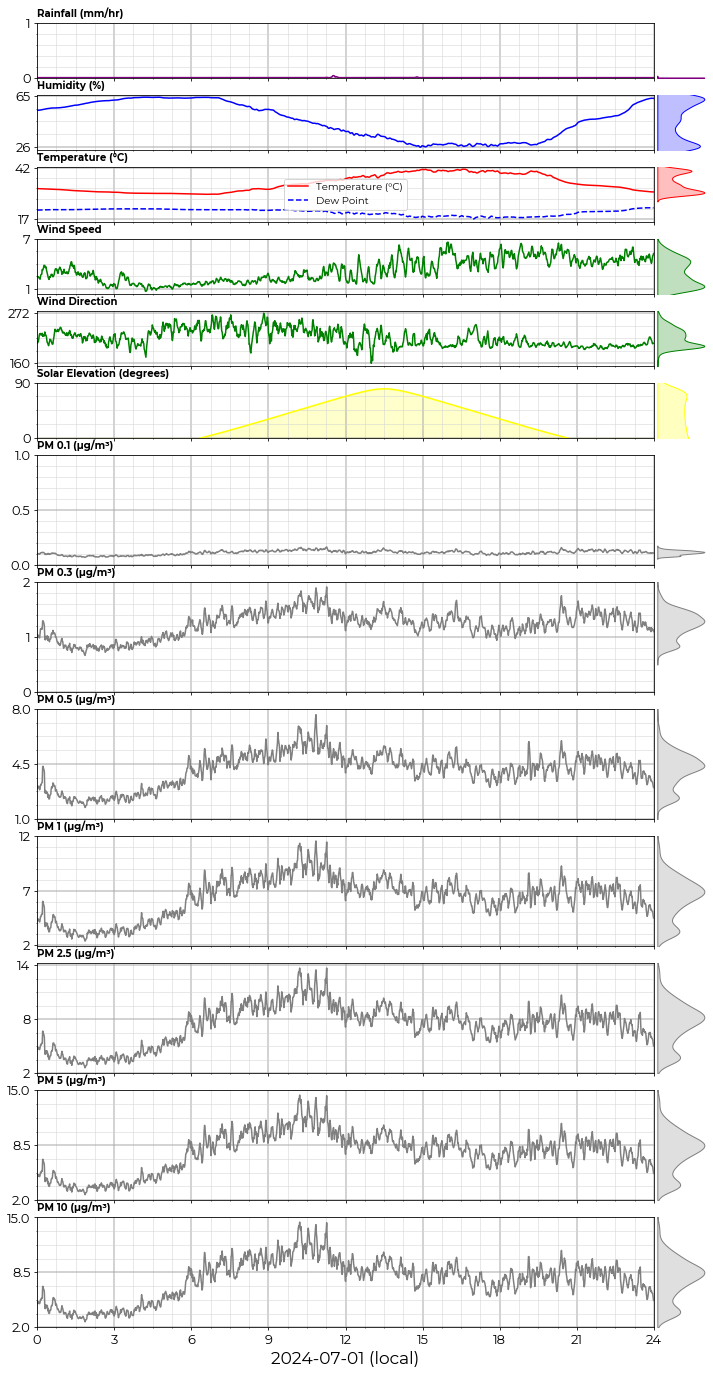

In [10]:

# Load the style sheet
plt.style.use('mints.mplstyle')

# Columns for the time series plots
time_series_columns = ['rainPerInterval', 'humidity', 'temperature','windSpeed','windAngle', 'sol_el', 
                       'pm0_1', 'pm0_3', 'pm0_5', 'pm1_0', 'pm2_5', 'pm5_0', 'pm10_0']

# Titles for the subplots
titles = ['Rainfall (mm/hr)', 'Humidity (%)', 'Temperature (°C)','Wind Speed','Wind Direction', 'Solar Elevation (degrees)',
          'PM 0.1 (µg/m³)', 'PM 0.3 (µg/m³)', 'PM 0.5 (µg/m³)', 'PM 1 (µg/m³)', 'PM 2.5 (µg/m³)',
          'PM 5 (µg/m³)', 'PM 10 (µg/m³)']


fig, axes = plt.subplots(nrows=len(time_series_columns), ncols=2, figsize=(12, 24),
                         gridspec_kw={'width_ratios': [1, 0.08],'height_ratios': [1, 1, 1, 1,1,1, 2, 2, 2, 2, 2, 2, 2], 'wspace': 0.01, 'hspace': 0.2})


def apply_custom_grid(ax):
    ax.grid(which='major', color='darkgrey', linewidth=2)
    ax.grid(which='minor', color='lightgrey', linewidth=1)


dt_min = df['dt'].min()
dt_max = np.ceil(df['dt'].max())

# Initialize lists to store min, max, and mid values
y_min = []
y_max = []
y_mid = []

date_label = f"{pd.to_datetime(df['datetime'].iloc[0]).strftime('%Y-%m-%d')} (local)"

colors = ['purple', 'blue', 'red','green','green', 'yellow', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']


for i, (col, title) in enumerate(zip(time_series_columns, titles)):
    # Time series plot
    if col == 'rainPerInterval':
        sns.lineplot(x='dt', y=col, data=df, ax=axes[i, 0], color='purple', label=title)
        axes[i, 0].legend_.remove()
        min_val = np.ceil(df[col].min())
        max_val = np.ceil(df[col].max())
        axes[i, 0].set_yticks([min_val, max_val])
        y_min.append(min_val)
        y_max.append(max_val)

    elif col == 'humidity':
        sns.lineplot(x='dt', y=col, data=df, ax=axes[i, 0], color='blue', label=title)
        axes[i, 0].legend_.remove()
        min_val = np.ceil(df[col].min())
        max_val = np.ceil(df[col].max())
        axes[i, 0].set_yticks([min_val, max_val])
        y_min.append(min_val)
        y_max.append(max_val)
        
    elif col == 'temperature':
        sns.lineplot(x='dt', y=col, data=df, ax=axes[i, 0], color='red', label=title)
        # Add dew point to temperature plot
        sns.lineplot(x='dt', y='dewPoint', data=df, ax=axes[i, 0], color='blue', linestyle='--', label='Dew Point')
        min_val = np.ceil(df['dewPoint'].min())
        max_val = np.ceil(df[col].max())
        axes[i, 0].set_yticks([min_val, max_val])
        y_min.append(min_val)
        y_max.append(max_val)

    elif col == 'windSpeed':
        sns.lineplot(x='dt', y=col, data=df, ax=axes[i, 0], color='green', label=title)
        axes[i, 0].legend_.remove()
        min_val = np.ceil(df[col].min())
        max_val = np.ceil(df[col].max())
        axes[i, 0].set_yticks([min_val, max_val])
        y_min.append(min_val)
        y_max.append(max_val)

    elif col == 'windAngle':
        sns.lineplot(x='dt', y=col, data=df, ax=axes[i, 0], color='green', label=title)
        axes[i, 0].legend_.remove()
        min_val = np.ceil(df[col].min())
        max_val = np.ceil(df[col].max())
        axes[i, 0].set_yticks([min_val, max_val])
        y_min.append(min_val)
        y_max.append(max_val)        
        
    elif col == 'sol_el':
        sns.lineplot(x='dt', y=col, data=df, ax=axes[i, 0], color='yellow', label=title)
        axes[i, 0].fill_between(df['dt'], df['sol_el'], color='yellow', alpha=0.2)
        axes[i, 0].set_ylim(0, 90)
        axes[i, 0].set_yticks([0, 90])
        axes[i, 0].legend_.remove()
        y_min.append(0)
        y_max.append(90)
        
    else:
        sns.lineplot(x='dt', y=col, data=df, ax=axes[i, 0], color='grey', label=title)
        
        min_val = np.floor(df[col].min()).astype(int)
        max_val = np.ceil(df[col].max()).astype(int)
        mid_val = (max_val + min_val) / 2
        axes[i, 0].set_yticks([min_val, mid_val, max_val])
        y_min.append(min_val)
        y_max.append(max_val)
        y_mid.append(mid_val)
        axes[i, 0].legend_.remove()

    axes[i, 0].set_title(title, fontsize=10, loc='left')
    
    
    if i == len(time_series_columns) - 1:
        axes[i, 0].set_xlabel(date_label)
        axes[i, 0].set_ylabel('')
        axes[i, 0].xaxis.set_major_locator(MultipleLocator(3))
    else:
        axes[i, 0].set_xlabel('')
        axes[i, 0].xaxis.set_major_locator(MultipleLocator(3))
        axes[i, 0].set_xticklabels([])  
        axes[i, 0].set_ylabel('')

    axes[i, 0].tick_params(axis='x')  
    
    axes[i, 0].set_xlim(dt_min, dt_max)
    
    apply_custom_grid(axes[i, 0])

    sns.kdeplot(df[col], ax=axes[i, 1], color=colors[i], fill=True,y=df[col])
    axes[i, 1].set_ylabel('')
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_yticklabels([])  
    axes[i, 1].set_xticklabels([])  
    axes[i, 1].set_ylim(y_min[i], y_max[i])

    axes[i, 1].grid(False)  
    axes[i, 1].spines['top'].set_visible(False)
    axes[i, 1].spines['right'].set_visible(False)
    axes[i, 1].spines['left'].set_visible(False)
    axes[i, 1].spines['bottom'].set_visible(False)

    axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig('time_series_plots_A4.pdf', dpi=fig.dpi)
plt.show()



/var/folders/77/p3609gd54ksfgsjngpspx22m0000gn/T/ipykernel_35655/3487624624.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.rename(columns=new_column_names, inplace=True)
/var/folders/77/p3609gd54ksfgsjngpspx22m0000gn/T/ipykernel_35655/3487624624.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_pivot = df_melted.pivot("Particle Count", "dt", "Value")


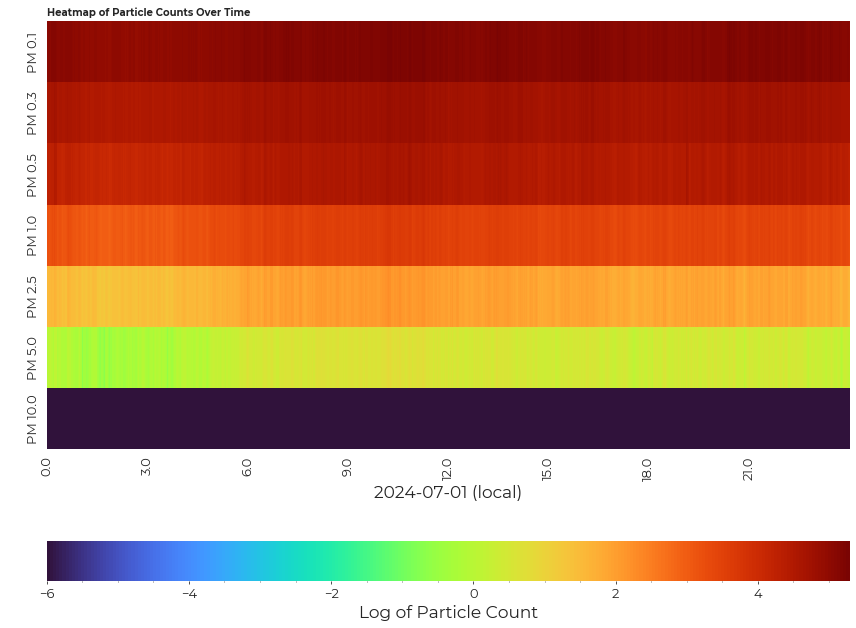

In [15]:
sns.axes_style()
sns.set_style("darkgrid", {"axes.facecolor": "1.0", "font.family": "Montserrat"})

# Heatmap for particle counts
cols_to_keep = ['dt', 'pc0_1', 'pc0_3', 'pc0_5', 'pc2_5', 'pc1_0', 'pc5_0', 'pc10_0']
df_subset = df[cols_to_keep]

new_column_names = {
    'pc0_1': 'PM 0.1',
    'pc0_3': 'PM 0.3',
    'pc0_5': 'PM 0.5',
    'pc2_5': 'PM 2.5',
    'pc1_0': 'PM 1.0',
    'pc5_0': 'PM 5.0',
    'pc10_0': 'PM 10.0'
}
df_subset.rename(columns=new_column_names, inplace=True)

df_melted = pd.melt(df_subset, id_vars=["dt"], var_name="Particle Count", value_name="Value")
df_pivot = df_melted.pivot("Particle Count", "dt", "Value")

desired_order = ['PM 0.1', 'PM 0.3', 'PM 0.5', 'PM 1.0', 'PM 2.5', 'PM 5.0', 'PM 10.0']
df_pivot = df_pivot.reindex(desired_order)

# Set the figure size to (12, 24)
plt.figure(figsize=(12, 9))
ax = sns.heatmap(np.log10(df_pivot + 0.000001), cmap="turbo", fmt="0.0f", alpha=1.0, 
                 cbar_kws={"label": "Log of Particle Count", "orientation": "horizontal"})

x_tick_freq = 180  # Frequency of x-axis ticks
x_tick_locations = np.arange(0, len(df_pivot.columns), x_tick_freq)
x_tick_labels = df_pivot.columns[x_tick_locations]

ax.set_xticks(x_tick_locations)
ax.set_xticklabels(x_tick_labels)

ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
ax.grid(False)
plt.title("Heatmap of Particle Counts Over Time",fontsize=10, loc='left')
plt.xlabel(date_label)  # Assuming you are labeling x-axis as Datetime
plt.ylabel(" ")
plt.tight_layout()
plt.savefig('heatmap_A4.png', dpi=fig.dpi)
plt.show()


pm sizes order should be flipped
log scale in the y scale. 
anything below or equalto zero to be left transparent. (not a number)
hours horizontal
in between tickmarks
3,6,9
y axis size in microns. (log of)
colorbar vertical